In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [62]:
data = pd.read_csv(path + "\stocks_data.csv", index_col = "Date").iloc[1:]

### Доходности акций

In [63]:
df1 = (data - data.shift()).iloc[1:]
df2 = (data.shift()).iloc[1:]
all_returns = df1.div(df2)

In [64]:
rj = all_returns.mean()

In [77]:
corr = df1.corr()
warmcorr = (corr).style.background_gradient(cmap='coolwarm')

### Матрица ковариаций

In [79]:
covars = all_returns.cov()

In [80]:
N = data.shape[1]
T = data.shape[0] - 1
epsilon = -0.5
delta = 0.3
rc = 0.04
h = np.zeros(N)
h[[1,6,8,16]] = 0.02
K = 20
l = 0.5

data - котировки 20 акций за полгода\
daily_returns - ежедневный доход\
markovitz - дисперсия, ст. отклонение и доход за полгода\
returns - доход в в момент времени t\
$r_j$ = $\frac{1}{T}\sum_{t=1}^{T}r_{tj}$

In [81]:
def create_constr(N, T, rj, rc, returns, epsilon, delta, K):
    constr1 =  np.concatenate(((returns - rj).values, np.identity(T), np.zeros((T, N))), axis = 1)
    constr2 =  np.concatenate((-(returns - rj).values, np.identity(T),  np.zeros((T,N))), axis = 1)
    constr3 = np.concatenate((np.ones(N), np.zeros(T + N)))
    constr4 = np.concatenate((np.zeros(N), np.zeros(T), np.ones(N)))
    constr5 = np.concatenate((np.zeros((T, N)), np.identity(T), np.zeros((T, N))), axis = 1)
    constr6 = np.concatenate((np.diag(rj), np.zeros((N, T + N))), axis = 1)
    constr7_1 = np.concatenate((np.identity(N), np.zeros((N, T)), -epsilon * np.identity(N)), axis = 1)
    constr7_2 = np.concatenate((np.identity(N), np.zeros((N, T)), -delta * np.identity(N)), axis = 1)
    
    constr = np.concatenate((constr1, constr2, [constr3], [constr4], constr5, constr6, constr7_1, constr7_2))
    
    rhs1 = np.concatenate((np.zeros(T + T), [1, K], np.zeros(T), np.zeros(N), np.zeros(N + N)))
    rhs2 = np.concatenate((np.ones(T + T), [0, 0], np.ones(T), np.ones(N), np.ones(N), np.full(N, -1)))
    rhs = np.array([rhs1, rhs2]).T
    
    return constr, rhs

In [82]:
def create_obj(N, T, rj, rc, h, l):
    return np.concatenate((-(1 - l) * (rj.values - rc*h), np.full(T, l/T), np.zeros(N)))

In [83]:
import pyomo.environ as pyo

model = pyo.AbstractModel()

model.m = pyo.Param(within=pyo.NonNegativeIntegers) #количество ограничений
model.n = pyo.Param(within=pyo.NonNegativeIntegers) #количество переменных всего 
model.nx = pyo.Param(within=pyo.NonNegativeIntegers) #количество обычных переменных
model.nz = pyo.Param(within=pyo.NonNegativeIntegers) #количество бинарных переменных
model.right = pyo.RangeSet(1, 2)

model.I = pyo.RangeSet(1, model.m) #индексы ограничений
model.J = pyo.RangeSet(1, model.n) #индексы переменных
model.Jx = pyo.RangeSet(1, model.nx) #индексы обычных переменных
model.Jz = pyo.RangeSet(1, model.nz) #индексы бинарных переменных

model.Ax = pyo.Param(model.I, model.Jx) #объявляем матрицу ограничений для x
model.Az = pyo.Param(model.I, model.Jz) #объявляем матрицу ограничений для z
model.rhs = pyo.Param(model.I, model.right) #rhs
model.c = pyo.Param(model.Jx)

model.x = pyo.Var(model.Jx, domain = pyo.Reals)
model.z = pyo.Var(model.Jz, domain = pyo.Binary)

def obj_expression(m):
    return pyo.summation(m.c, m.x)
    #return l/T*sum(m.x[-T:]) - (1 - l) * np.dot((rj.values - rc*h), m.x[:N])

model.OBJ = pyo.Objective(rule=obj_expression)

def constraint_rule(m, i):
    if m.rhs[i,2] == -1:
        return sum(m.Ax[i,j] * m.x[j] for j in m.Jx) + sum(m.Az[i,j] * m.z[j] for j in m.Jz) <= m.rhs[i,1]
    if m.rhs[i,2] == 0:
        return sum(m.Ax[i,j] * m.x[j] for j in m.Jx) + sum(m.Az[i,j] * m.z[j] for j in m.Jz) == m.rhs[i,1]
    if m.rhs[i,2] == 1:
        return sum(m.Ax[i,j] * m.x[j] for j in m.Jx) + sum(m.Az[i,j] * m.z[j] for j in m.Jz) >=m.rhs[i,1]
    
model.constraints = pyo.Constraint(model.I, rule = constraint_rule)

In [84]:
def solve(m, n, nx, nz, c, A, rhs):
    rules = {None:{
        'm': {None: m},
        'n': {None: n},
        'nx': {None: nx},
        'nz': {None: nz},
        'Ax': {(i + 1, j + 1): A[i][j] for i in range(m) for j in range(nx)},
        'Az': {(i + 1, j + 1): A[i][j + nx] for i in range(m) for j in range(nz)},
        'rhs': {(i + 1, j + 1): rhs[i][j] for i in range(m) for j in range(2)},
        'c': {i + 1: c[i] for i in range(nx)}
        }}
    ins = model.create_instance(rules)
    opt = pyo.SolverFactory('glpk')
    opt.solve(ins)
    res = [pyo.value(ins.x[i]) for i in range(1, nx+1)]
    bins = [pyo.value(ins.z[i]) for i in range(1, nz+1)]
    return res, bins

In [85]:
constr, rhs = create_constr(N, T, rj, rc, all_returns, 0, delta, K)
m = constr.shape[0]
n = constr.shape[1]
nz = N
nx = n - nz

In [86]:
c = create_obj(N, T, rj, rc, h, l)

In [87]:
res, bins = solve(m, n, nx, nz, c, constr, rhs)
weights = res[:N]

In [88]:
weights

[-0.0,
 -0.0,
 0.116302193330545,
 0.162488030063287,
 0.0959485365481388,
 0.120766998177286,
 -0.0,
 -0.0,
 -0.0,
 0.262945429855208,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 0.0202177744017753,
 -0.0,
 0.113674468583181,
 0.0427987557404795,
 0.0648578133000995,
 -0.0,
 -0.0]

### Стандартное отклонение портфеля, в процентах:

In [89]:
def stdev(weights, covars):
    return np.sqrt(np.dot(np.dot(np.transpose(weights), covars), np.array(weights)))### Стандартное отклонение портфеля, в процентах:

In [90]:
stdev(weights, covars)

0.007986593763676383

### Доходность портфеля, в процентах:

In [91]:
np.dot(rj, weights)

0.0015472225344901388

In [92]:
lambdas = np.arange(0, 1.1, 0.1)
K = 17
l_wo = []
constr, rhs = create_constr(N, T, rj, rc, all_returns, -0.2, 0.15, K)
m = constr.shape[0]
n = constr.shape[1]
nz = N
nx = n - nz
for l in lambdas:
    c = create_obj(N, T, rj, rc, h, l)
    res, bins = solve(m, n, nx, nz, c, constr, rhs)
    weights = res[:N]
    l_wo.append([K, l, np.dot(rj, weights), stdev(weights, covars)])

In [93]:
l_wo = np.array(l_wo)

In [2]:
l_wo = np.array([[1.70000000e+01, 0.00000000e+00, 4.12779630e-03, 1.72061690e-02],
       [1.70000000e+01, 1.00000000e-01, 4.08849302e-03, 1.46521447e-02],
       [1.70000000e+01, 2.00000000e-01, 3.87088244e-03, 1.27172648e-02],
       [1.70000000e+01, 3.00000000e-01, 3.73708502e-03, 1.18213712e-02],
       [1.70000000e+01, 4.00000000e-01, 3.07469826e-03, 1.01343739e-02],
       [1.70000000e+01, 5.00000000e-01, 2.02659884e-03, 8.50267891e-03],
       [1.70000000e+01, 6.00000000e-01, 1.86648007e-03, 8.38774875e-03],
       [1.70000000e+01, 7.00000000e-01, 1.75033256e-03, 8.29245015e-03],
       [1.70000000e+01, 8.00000000e-01, 1.62284841e-03, 8.24450149e-03],
       [1.70000000e+01, 9.00000000e-01, 1.52898327e-03, 8.15312502e-03],
       [1.70000000e+01, 1.00000000e+00, 1.52343129e-03, 8.14846097e-03]])

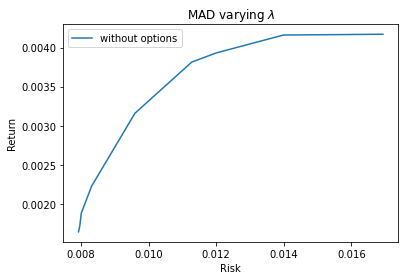

In [94]:
plt.plot(l_wo[:, 3], l_wo[:, 2], label = 'without options')
plt.xlabel("Risk")
plt.ylabel("Return")
plt.legend()
plt.title("MAD varying $\lambda$")
plt.show()

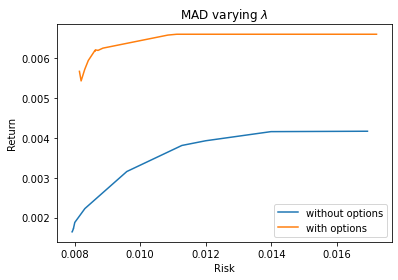

In [96]:
plt.plot(l_wo[:, 3], l_wo[:, 2], label = 'without options')
plt.plot(l_o[:, 3], l_o[:, 2], label = 'with options')
plt.xlabel("Risk")
plt.ylabel("Return")
plt.legend()
plt.title("MAD varying $\lambda$")
plt.show()

In [95]:
l_o = np.array([[1.70000000e+01, 0.00000000e+00, 6.60875298e-03, 1.11153278e-02],
       [1.70000000e+01, 1.00000000e-01, 6.58798652e-03, 1.08463169e-02],
       [1.70000000e+01, 2.00000000e-01, 6.25951812e-03, 8.86480687e-03],
       [1.70000000e+01, 3.00000000e-01, 6.20288121e-03, 8.71557129e-03],
       [1.70000000e+01, 4.00000000e-01, 6.21363500e-03, 8.64525252e-03],
       [1.70000000e+01, 5.00000000e-01, 6.18349544e-03, 8.62102896e-03],
       [1.70000000e+01, 6.00000000e-01, 6.20528586e-03, 8.62438145e-03],
       [1.70000000e+01, 7.00000000e-01, 5.94847436e-03, 8.41873540e-03],
       [1.70000000e+01, 8.00000000e-01, 5.72442361e-03, 8.30973652e-03],
       [1.70000000e+01, 9.00000000e-01, 5.43578357e-03, 8.19985634e-03],
       [1.70000000e+01, 1.00000000e+00, 5.67566935e-03, 8.14846097e-03]])
l_o = np.concatenate([[np.array([17, 1,  6.60875298e-03, 1.72061690e-02])], l_o])